In [40]:
!pip install numpy pandas matplotlib scikit-learn tensorflow tf tensor

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [42]:
# Load your CSV file into a DataFrame
file_path = 'MSFT-1.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Normalize the data using Min-Max Scaling
def normalize_data(df):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

# Standardize the data using Standard Scaling
def standardize_data(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)


# Add technical indicators
def add_technical_indicators(df):
    # Moving Averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # Daily Returns
    df['Daily Returns'] = df['Close'].pct_change()

    # Volatility (20-day rolling standard deviation of daily returns)
    df['Volatility'] = df['Daily Returns'].rolling(window=20).std()

    return df


# Apply preprocessing steps
# Normalize or standardize as required (comment out the one you don't need)
# normalized_data = normalize_data(data)
# standardized_data = standardize_data(data)

# Add technical indicators
data_with_indicators = add_technical_indicators(data)

# Display the first few rows of the data with indicators
data_with_indicators.head()


,Date,Open,High,Low,Close,Volume,MA20,MA50,Daily Returns,Volatility
0,3/13/1986,0.088542,0.101563,0.088542,0.097222,1031788800,NaN,NaN,NaN,NaN
1,3/14/1986,0.097222,0.102431,0.097222,0.100694,308160000,NaN,NaN,0.035712,NaN
2,3/17/1986,0.100694,0.103299,0.100694,0.102431,133171200,NaN,NaN,0.017250,NaN
3,3/18/1986,0.102431,0.103299,0.098958,0.099826,67766400,NaN,NaN,-0.025432,NaN
4,3/19/1986,0.099826,0.100694,0.097222,0.098090,47894400,NaN,NaN,-0.017390,NaN


In [43]:

# Load your CSV file into a DataFrame
file_path = 'MSFT-1.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Preprocess the data
# Example: Convert 'Date' to a numeric format or remove it
data['Date'] = pd.to_datetime(data['Date']).map(pd.Timestamp.timestamp)

# Feature engineering and selection
# ...

# Split data into features and target
features = data.drop(['Close'], axis=1)
target = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize data for LSTM and RandomForest
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to create a dataset for LSTM
def create_lstm_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Prepare data for LSTM
time_steps = 10  # Adjust the time steps
X_train_lstm, y_train_lstm = create_lstm_dataset(X_train_scaled, y_train.values, time_steps)
X_test_lstm, y_test_lstm = create_lstm_dataset(X_test_scaled, y_test.values, time_steps)

# Ensure data is in float32 format
X_train_lstm = X_train_lstm.astype('float32')
y_train_lstm = y_train_lstm.astype('float32')

# Train Improved LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)

# Train Tuned Random Forest Model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make Predictions
lstm_predictions = lstm_model.predict(X_test_lstm)
rf_predictions = rf_model.predict(X_test_scaled).reshape(-1,1)

# Align predictions for ensemble
min_length = min(len(lstm_predictions), len(rf_predictions))
ensemble_predictions = (lstm_predictions[:min_length] + rf_predictions[:min_length]) / 2

# Evaluate Ensemble Model
ensemble_error = mean_squared_error(y_test_lstm[:min_length], ensemble_predictions)
print("Ensemble Mean Squared Error:", ensemble_error)


Epoch 1/20


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4234.2939
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3504.6091
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3445.4199
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3680.3831
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3465.4370
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3430.8533
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3616.2310
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3428.4587
Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3676.9556
Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3305.4365
Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3509.7874
Epoch 12/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3459.0718
Epoch 13/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3363.9458
Epoch 14/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3437.7180
Epoch 15/20
227/227 ━━━━━━

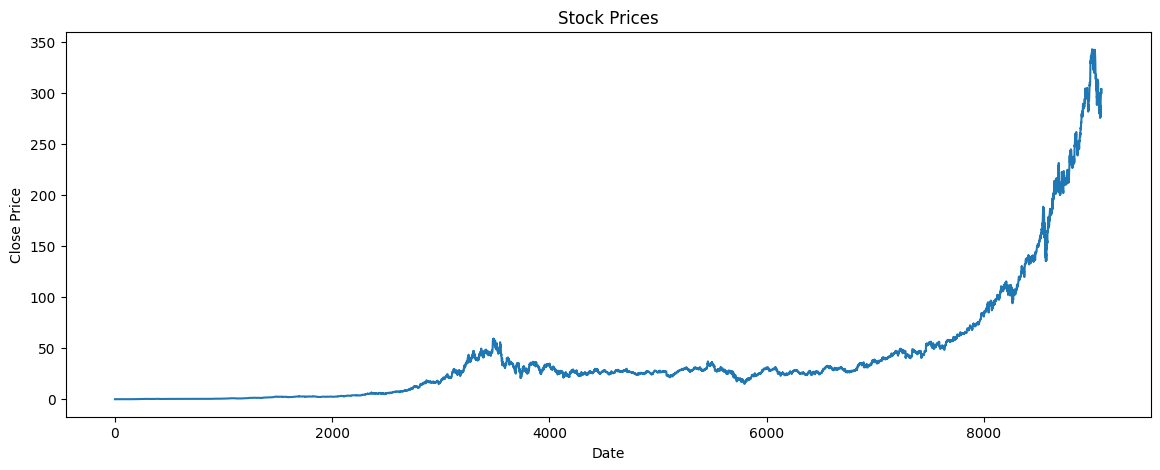

In [44]:
#Visualize the data
plt.figure(figsize=(14, 5))
plt.plot(data['Close'])
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


Epoch 1/20


/tmp/ipykernel_6636/804948594.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Fill missing values
/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.4906 - val_loss: 0.4227
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.4470 - val_loss: 0.4236
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.4759 - val_loss: 0.4234
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.4372 - val_loss: 0.4236
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.4507 - val_loss: 0.4191
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.4307 - val_loss: 0.4206
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.4604 - val_loss: 0.4189
Epoch 8/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.4439 - val_loss: 0.4191
Epoch 9/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.4621 - val_loss: 0.4186
Epoch 10/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.4316 - val_loss: 0.4195
Epoch 11/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.4362 - val_loss: 0.4203
Epoch 12/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


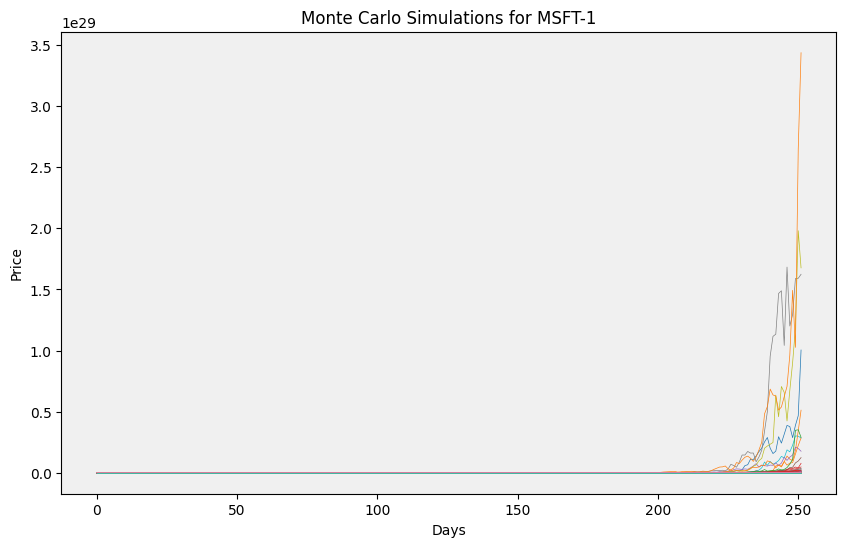

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Define the function to create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Define the function to train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])
    
    return model

# Define the function to perform Monte Carlo simulations
def monte_carlo_simulations(last_price, days, mu, sigma, simulations):
    results = np.zeros((days, simulations))
    for sim in range(simulations):
        prices = [last_price]
        for _ in range(days):
            prices.append(prices[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal()))
        results[:, sim] = prices[1:]
    return results

# Function to calculate the annualized mean and standard deviation of log returns
def calculate_annualized_params(df):
    log_returns = np.log(df['Close'] / df['Close'].shift(1))
    mu = np.mean(log_returns) * 252
    sigma = np.std(log_returns) * np.sqrt(252)
    return mu, sigma

# Process the data, train models, and perform simulations for each stock
def analyze_stocks(stock_list, n_steps, days_to_simulate, simulations):
    models_scalers = {}
    simulation_results = {}

    for stock in stock_list:
        df = pd.read_csv(f'{stock}.csv')
        df.fillna(method='ffill', inplace=True)  # Fill missing values
        df['Daily Returns'] = df['Close'].pct_change()

        features = ['Open', 'High', 'Low', 'Close', 'Volume']
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[features])

        X, y = create_sequences(scaled_features, n_steps)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        model = train_lstm_model(X_train, y_train, X_val, y_val)
        models_scalers[stock] = (model, scaler)

        predicted_price = df['Close'].iloc[-1]

        mu, sigma = calculate_annualized_params(df)

        simulated_prices = monte_carlo_simulations(predicted_price, days_to_simulate, mu, sigma, simulations)
        simulation_results[stock] = simulated_prices

    return simulation_results

# List of stock tickers
stock_list = ['MSFT-1']
n_steps = 50  # Number of days to look back
days_to_simulate = 252  # Number of days to simulate in the future
simulations = 5000  # Number of simulation paths

# Run the analysis
simulation_results = analyze_stocks(stock_list, n_steps, days_to_simulate, simulations)

# Plot the results
"""
for stock, simulations in simulation_results.items():
    plt.figure(figsize=(10, 5))
    for i in range(min(simulations.shape[1], 100)):  # Plot a maximum of 10 simulations for readability
        plt.plot(simulations[:, i], label=f'Simulation {i}')
    plt.title(f'Monte Carlo Simulations for {stock}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

"""


for stock, simulations in simulation_results.items():
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = '#f0f0f0' # Light gray background
    
    # Plot all simulations without individual labels
    for i in range(simulations.shape[1]):  
        plt.plot(simulations[:, i], linewidth=0.5)  # Thinner lines

    plt.title(f'Monte Carlo Simulations for {stock}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.grid(False)        # Remove gridlines
    plt.legend().remove() # Remove legend
    plt.show()
